# __I. Setup__

## i. Imports

In [30]:
import os
import shutil
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## ii. GPU

### a. Check if GPU is available

In [31]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13766957037144893845
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5833228288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 844644838117307430
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1734012686.957905  100261 gpu_device.cc:2022] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### b. Limit memory on GPU

In [32]:
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
    tf.config.experimental.set_memory_growth(gpu, True)

# __II. Data Preprocessing__

## i. Define dataset path and classes

In [33]:
DATA_DIR = Path("BiNet_Dataset")
CLASSES = ["Corrosionstain", "Cracks", "Exposedbars", "Spalling"]

## ii. Remove corrupted files

In [34]:
def remove_corrupted_files(data_dir, classes):
    for class_name in classes:
        class_dir = data_dir / class_name
        for img_file in class_dir.iterdir():
            try:
                img = Image.open(img_file)
                img.verify()  # Verify integrity
            except (IOError, SyntaxError):
                print(f"Removing corrupted file: {img_file}")
                os.remove(img_file)

remove_corrupted_files(DATA_DIR, CLASSES)

## iii. Check class distribution

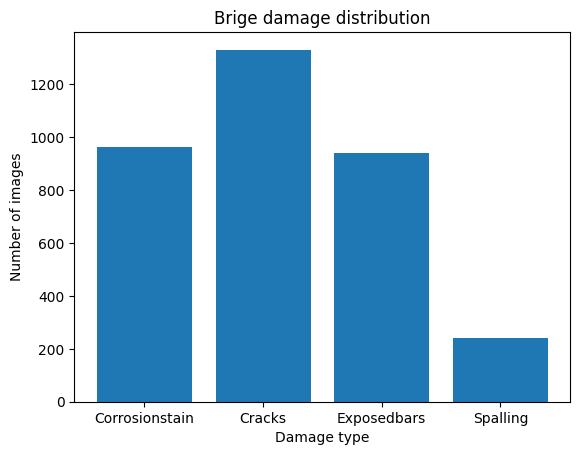

dict_values([961, 1330, 940, 240])

In [35]:
class_counts = {class_name: len(list((DATA_DIR / class_name).glob("*.png"))) for class_name in CLASSES}
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Brige damage distribution")
plt.xlabel("Damage type")
plt.ylabel("Number of images")
plt.show()
class_counts.values()

Class imbalance is present. It will be addressed using weights.

## iv. Split dataset

### a. Function to split dataset into training(70%), valuation(10%), and testing sets(20%).

In [36]:
def split_data(data_dir, classes, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    train_dir = data_dir / "train"
    val_dir = data_dir / "val"
    test_dir = data_dir / "test"

    for dir_path in [train_dir, val_dir, test_dir]:
        dir_path.mkdir(exist_ok=True, parents=True)

    for class_name in classes:
        all_files = list((data_dir / class_name).glob("*.png"))
        np.random.shuffle(all_files)

        train_count = int(len(all_files) * train_ratio)
        val_count = int(len(all_files) * val_ratio)

        train_files = all_files[:train_count]
        val_files = all_files[train_count:train_count + val_count]
        test_files = all_files[train_count + val_count:]

        for subset, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
            subset_class_dir = subset / class_name
            subset_class_dir.mkdir(exist_ok=True)
            for file in files:
                shutil.copy(file, subset_class_dir)

split_data(DATA_DIR, CLASSES)            

### b. Declare directory variables 

In [37]:
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"

### c. Declare class variables for the data sets

In [38]:
def get_class_dir(dir):
    class1_dir = dir / "Corrosionstain"
    class2_dir = dir / "Cracks"
    class3_dir = dir / "Exposedbars"
    class4_dir = dir / "Spalling"
    return class1_dir, class2_dir, class3_dir, class4_dir

TRAIN_CORROSIONSTAIN_DIR, TRAIN_CRACKS_DIR, TRAIN_EXPOSEDBARS_DIR, TRAIN_SPALLING_DIR  = get_class_dir(TRAIN_DIR)
VAL_CORROSIONSTAIN_DIR, VAL_CRACKS_DIR, VAL_EXPOSEDBARS_DIR, VAL_SPALLING_DIR  = get_class_dir(VAL_DIR)
TEST_CORROSIONSTAIN_DIR, TEST_CRACKS_DIR, TEST_EXPOSEDBARS_DIR, TEST_SPALLING_DIR  = get_class_dir(TEST_DIR)

### d. Check the number of images in the sets  

In [39]:
def dir_len(dir):
    return len(os.listdir(dir))

print("Training Set:")
print("   Corrosionstain: " + str(dir_len(TRAIN_CORROSIONSTAIN_DIR)) + " images")
print("   Cracks: " + str(dir_len(TRAIN_CRACKS_DIR)) + " images")
print("   Exposedbars: " + str(dir_len(TRAIN_EXPOSEDBARS_DIR)) + " images")
print("   Spalling: " + str(dir_len(TRAIN_SPALLING_DIR)) + " images")

print("\nValuation Set:")
print("   Corrosionstain: " + str(dir_len(VAL_CORROSIONSTAIN_DIR)) + " images")
print("   Cracks: " + str(dir_len(VAL_CRACKS_DIR)) + " images")
print("   Exposedbars: " + str(dir_len(VAL_EXPOSEDBARS_DIR)) + " images")
print("   Spalling: " + str(dir_len(VAL_SPALLING_DIR)) + " images")

print("\nTesting Set:")
print("   Corrosionstain: " + str(dir_len(TEST_CORROSIONSTAIN_DIR)) + " images")
print("   Cracks: " + str(dir_len(TEST_CRACKS_DIR)) + " images")
print("   Exposedbars: " + str(dir_len(TEST_EXPOSEDBARS_DIR)) + " images")
print("   Spalling: " + str(dir_len(TEST_SPALLING_DIR)) + " images")

Training Set:
   Corrosionstain: 958 images
   Cracks: 1327 images
   Exposedbars: 938 images
   Spalling: 240 images

Valuation Set:
   Corrosionstain: 390 images
   Cracks: 543 images
   Exposedbars: 376 images
   Spalling: 96 images

Testing Set:
   Corrosionstain: 638 images
   Cracks: 888 images
   Exposedbars: 628 images
   Spalling: 165 images


## v. Create Generators

### a. Data augmentation for training data

In [40]:
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    dtype='float32'
)

### b. Rescale for validation and test data

In [41]:
val_test_gen = ImageDataGenerator(
    rescale=1.0/255,
    dtype='float32'  
)

### c. Load data using generators

In [42]:
IMG_WIDTH = IMG_HEIGHT = 224
BATCH_SIZE = 64

train_generator = data_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3463 images belonging to 4 classes.
Found 1405 images belonging to 4 classes.
Found 2319 images belonging to 4 classes.


### d. Address class imbalance using weights

In [43]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.903705636743215), 1: np.float64(0.6524114544084401), 2: np.float64(0.9229744136460555), 3: np.float64(3.607291666666667)}


## vi. Data visualization

### a. Show sample images from training set

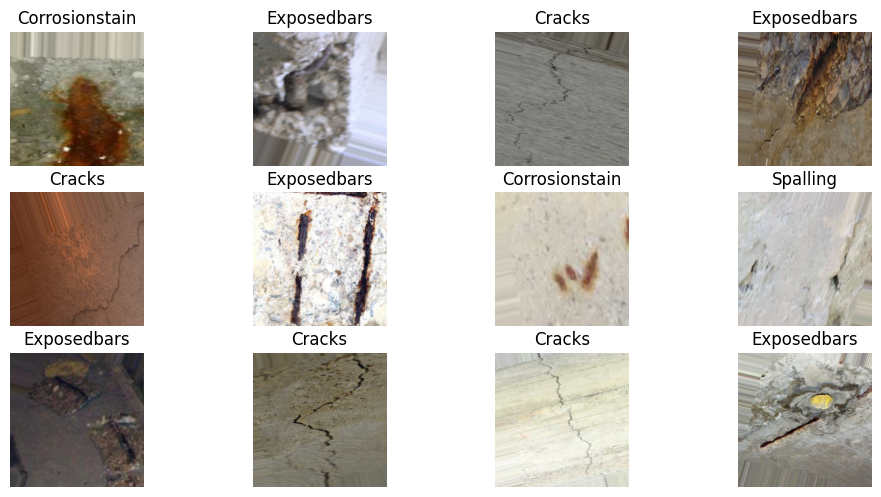

In [44]:
def plot_sample_images(generator, class_labels):
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

class_labels = list(train_generator.class_indices.keys())
plot_sample_images(train_generator, class_labels)

# __III. Convolutional Neural Networks: 14 Model Trials__

### Function for model accuracy and loss plot

In [45]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

## i. Trial 1: model_uno

### a. Model creation

In [46]:
model_uno = models.Sequential()
model_uno.add(layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))) 

model_uno.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_uno.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_uno.add(layers.Flatten())

model_uno.add(layers.Dense(128, activation='relu'))
model_uno.add(layers.Dense(len(CLASSES), activation='softmax'))  

model_uno.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### b. Model summary

In [47]:
model_uno.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    50,466,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,468,356 (192.52 MB)

 Trainable params: 50,468,356 (192.52 MB)

 Non-trainable params: 0 (0.00 B)

### c. Model fitting

In [50]:
model_uno_history = model_uno.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10, 
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 771ms/step - accuracy: 0.7229 - loss: 0.7735 - val_accuracy: 0.7601 - val_loss: 0.7047
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 698ms/step - accuracy: 0.7209 - loss: 0.7766 - val_accuracy: 0.7295 - val_loss: 0.7561
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 714ms/step - accuracy: 0.7232 - loss: 0.7750 - val_accuracy: 0.7523 - val_loss: 0.7124
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 660ms/step - accuracy: 0.7359 - loss: 0.7497 - val_accuracy: 0.7609 - val_loss: 0.7271
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 726ms/step - accuracy: 0.7366 - loss: 0.7281 - val_accuracy: 0.7381 - val_loss: 0.6983
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 679ms/step - accuracy: 0.7345 - loss: 0.7520 - val_accuracy: 0.7580 - val_loss: 0.6803
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 680ms/step - accuracy: 0.7351 - loss: 0.7257 - val_accuracy: 0.7786 - val_loss: 0.6506
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 51s 920ms/step - accuracy: 0.7427 - loss: 0.7271 - val_accu

KeyboardInterrupt: 

### d. Model history 

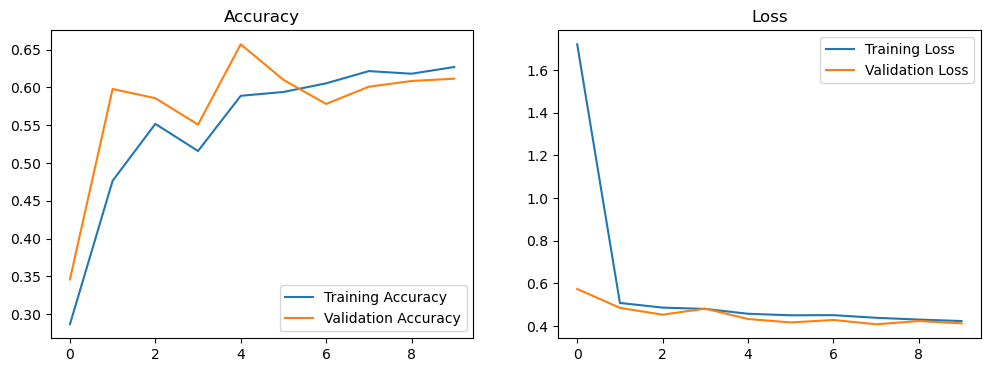

In [71]:
plot_training_history(model_uno_history)